In [26]:
import pandas as pd 
import geopandas as gpd
from shapely.geometry import Point
from bbox import * 
from pytz import timezone
import os
from shapely.wkt import loads
import numpy as np
import xarray as xr
import gc

# Sensor Data Only

In [27]:
sensor_df=pd.read_csv('../../data/sensor_data/hourly_raw_am.csv', index_col=0)
sensor_df=sensor_df[['latitude', 'longitude', 'date_local',
       'time_local', 'sample_measurement', 'site_number', 'county','state']]
sensor_df=sensor_df[~sensor_df['sample_measurement'].isna()]
sensor_df['time'] = pd.to_datetime(sensor_df['date_local'] + ' ' + sensor_df['time_local'])


no2_hours = pd.read_csv("../../data/tempo_data/no2_file_hours.csv")
no2_hours=list(no2_hours['time_hr_ct'])
time_list = np.array(no2_hours, dtype="datetime64[ns]")
sensor_time_list = np.array(sensor_df['time'].unique(), dtype="datetime64[ns]")
seta = set(sensor_time_list)
setb = set(time_list)
union_set = seta & setb
full_time_list = list(union_set)
# Convert to pandas datetime objects
pd_datetime_list = list(pd.to_datetime(full_time_list))
sensor_df['time']=pd.to_datetime(sensor_df['time'])
sensor_df=sensor_df[sensor_df['time'].isin(pd_datetime_list)]

In [28]:
# Create a GeoDataFrame
gdf = gpd.GeoDataFrame(
    sensor_df,
    geometry=[Point(xy) for xy in zip(sensor_df["longitude"], sensor_df["latitude"])],
    crs="EPSG:4326"  # WGS84 coordinate reference system
)
gdf=gdf[['latitude','longitude','geometry']].drop_duplicates()

# Create gridded GDF
res = 0.01 
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x

grid_gdf["lat"] = round(grid_gdf["lat"],3)
grid_gdf["lon"] = round(grid_gdf["lon"],3)
grid_gdf=grid_gdf.drop_duplicates()
key = gpd.sjoin(grid_gdf, gdf, how="inner", predicate="intersects")
key=key[['geometry','lat','lon','latitude','longitude']]


sensor_df_joined = pd.merge(sensor_df, key, on=['latitude','longitude'], how='left')
# sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'sample_measurement']]
sensor_df_joined=sensor_df_joined.rename(columns={'sample_measurement':'no2'})

del gdf
del sensor_df
del grid_cells
del key
gc.collect()

sensor_df_joined.to_csv('../../data/sensor_data/final_sensor_withgrid.csv')

/var/tmp/ipykernel_5508/1364800076.py:25: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lat"] = grid_gdf.geometry.centroid.y
/var/tmp/ipykernel_5508/1364800076.py:26: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lon"] = grid_gdf.geometry.centroid.x


In [6]:
%%capture
unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))

for i in range(16,len(unique_months)):
    month=unique_months[i]
    month_str=str(month)
    print(month_str)
    dates_in_month = sorted([date for date in full_time_list if str(pd.to_datetime(date).to_period('M')) == month_str])

    # Initialize an empty list to hold xarrays
    xarrays_list = []

    for i, time in enumerate(dates_in_month):
        if i % 500 == 0:
            print(i)
        no2_df = sensor_df_joined[sensor_df_joined['time']==time]
        grid_gdf["lat"] = round(grid_gdf["lat"],3)
        grid_gdf["lon"] = round(grid_gdf["lon"],3)
        no2_df["lat"] = round(no2_df["lat"],3)
        no2_df["lon"] = round(no2_df["lon"],3)
        time_df = pd.merge(grid_gdf, no2_df, on=['lat', 'lon'], how='left')
        time_df=time_df.drop_duplicates()
        time_df['time'] = time_df['time'].fillna(time)

        # Pivot the data into a 2D array
        time_df_pivot = time_df.pivot(index="lat", columns="lon", values="no2")

        # Convert to xarray
        da = xr.DataArray(
            time_df_pivot.values,
            coords={
                "lat": time_df_pivot.index.values,
                "lon": time_df_pivot.columns.values,
            },
            dims=["lat", "lon"],
            name="no2"
        )
        ds_expanded = da.expand_dims({'time': [time]})
        # Append the expanded xarray to the list
        xarrays_list.append(ds_expanded)

    # Concatenate all the xarrays in the list along the 'time' dimension
    final_ds = xr.concat(xarrays_list, dim='time')

    final_ds.to_netcdf(f'../../data/y_sensor_only/sensor_{month_str}.nc')
    
    

# Sensor and Mobile Data

In [29]:
sensor_df_joined=pd.read_csv('../../data/sensor_data/final_sensor_withgrid.csv')
mobile_df = pd.read_csv('../../data/mobile_air_data/final_mobile_withgrid.csv')

sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'no2']]
mobile_df=mobile_df[['lat', 'lon', 'time', 'weighted_no2']]
full_df = pd.merge(sensor_df_joined, mobile_df, on=['lat', 'lon', 'time'], how='outer')
full_df['sensor?'] = np.where(full_df['no2'].isna(), 0, 1)
full_df['no2'] = full_df['no2'].fillna(full_df['weighted_no2'])
full_df.drop('weighted_no2', axis=1,inplace=True)
pd_datetime_list = list(pd.to_datetime(full_df['time']))

In [30]:
# Create gridded GDF
res = 0.01 
lon_bins = np.arange(lon_min+0.005, lon_max, res)
lat_bins = np.arange(lat_min+0.005, lat_max, res)

grid_cells = []
for x in lon_bins[:-1]:
    for y in lat_bins[:-1]:
        grid_cells.append(
            Point(x, y).buffer(res / 2).envelope
        )

grid_gdf = gpd.GeoDataFrame(
    {"geometry": grid_cells},
    crs="EPSG:4326"
)
grid_gdf["lat"] = grid_gdf.geometry.centroid.y
grid_gdf["lon"] = grid_gdf.geometry.centroid.x

grid_gdf["lat"] = round(grid_gdf["lat"],3)
grid_gdf["lon"] = round(grid_gdf["lon"],3)
full_df["lat"] = round(full_df["lat"],3)
full_df["lon"] = round(full_df["lon"],3)

/var/tmp/ipykernel_5508/2120224353.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lat"] = grid_gdf.geometry.centroid.y
/var/tmp/ipykernel_5508/2120224353.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grid_gdf["lon"] = grid_gdf.geometry.centroid.x


In [31]:
unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))
unique_months

[Period('2023-08', 'M'),
 Period('2023-09', 'M'),
 Period('2023-10', 'M'),
 Period('2023-11', 'M'),
 Period('2023-12', 'M'),
 Period('2024-01', 'M'),
 Period('2024-02', 'M'),
 Period('2024-03', 'M'),
 Period('2024-04', 'M'),
 Period('2024-05', 'M'),
 Period('2024-06', 'M'),
 Period('2024-07', 'M'),
 Period('2024-08', 'M'),
 Period('2024-09', 'M'),
 Period('2024-10', 'M'),
 Period('2024-11', 'M'),
 Period('2024-12', 'M'),
 Period('2025-01', 'M'),
 Period('2025-02', 'M'),
 Period('2025-03', 'M'),
 Period('2025-04', 'M'),
 Period('2025-05', 'M')]

In [33]:
unique_months = sorted(set(pd.to_datetime(date).to_period('M') for date in pd_datetime_list))

for i in range(16,len(unique_months)):
    month=unique_months[i]
    month_str=str(month)
    print(month_str)
    dates_in_month = sorted([date for date in full_time_list if str(pd.to_datetime(date).to_period('M')) == month_str])

    # Initialize an empty list to hold xarrays
    xarrays_list = []

    for i, time in enumerate(dates_in_month):

        print(i)
        no2_df = full_df[full_df['time'].astype(str) == str(time)]
        time_df = pd.merge(grid_gdf, no2_df, on=['lat', 'lon'], how='left')
        time_df['time'] = time_df['time'].fillna(time)

        # Pivot the data for no2
        no2_pivot = time_df.pivot(index="lat", columns="lon", values="no2")

        # Pivot the data for sensor
        sensor_pivot = time_df.pivot(index="lat", columns="lon", values="sensor?")

        # Convert no2 to xarray
        no2_da = xr.DataArray(
            no2_pivot.values,
            coords={
                "lat": no2_pivot.index.values,
                "lon": no2_pivot.columns.values,
            },
            dims=["lat", "lon"],
            name="no2"
        )

        # Convert sensor to xarray
        sensor_da = xr.DataArray(
            sensor_pivot.values,
            coords={
                "lat": sensor_pivot.index.values,
                "lon": sensor_pivot.columns.values,
            },
            dims=["lat", "lon"],
            name="sensor?"
        )

        # Combine both variables into a single dataset
        ds = xr.Dataset(
            {
                "no2": no2_da,
                "sensor?": sensor_da,
            }
        )

        # Expand dataset along the 'time' dimension
        ds_expanded = ds.expand_dims({'time': [time]})

        # Append the expanded xarray dataset to the list
        xarrays_list.append(ds_expanded)

    # Concatenate all the xarray datasets in the list along the 'time' dimension
    final_ds = xr.concat(xarrays_list, dim='time')
    final_ds.to_netcdf(f'../../data/y_sensor_mobile/sensor_mobile_{month_str}.nc')


2024-12
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


284


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


285


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


286


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


287


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


288


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


289


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


290


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


291


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


292


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


293


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


294


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


295


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


296


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


297


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


298


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


299


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


300


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


301


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


302


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


303


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


304


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


305


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


306


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


307


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


308


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


309


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


310


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


311


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


312


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


313


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


314


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


315


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


316


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


317


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


318


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


319


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


320


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


321


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


322


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


323


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


324


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


325


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


326


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


327


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


328


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


329


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


330


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


331


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2025-01
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


284


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


285


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


286


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


287


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


288


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


289


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


290


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


291


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


292


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


293


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


294


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


295


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


296


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


297


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


298


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


299


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


300


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


301


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


302


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


303


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


304


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


305


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


306


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


307


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


308


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


309


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


310


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


311


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


312


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


313


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


314


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


315


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


316


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


317


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


318


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


319


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2025-02
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2025-03
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


284


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


285


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


286


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


287


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


288


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


289


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


290


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


291


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


292


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


293


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


294


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


295


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


296


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


297


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


298


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


299


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


300


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


301


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


302


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


303


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


304


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


305


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


306


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


307


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


308


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


309


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


310


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


311


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


312


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


313


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


314


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


315


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


316


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


317


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


318


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


319


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


320


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


321


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


322


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


323


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


324


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


325


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


326


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


327


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


328


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


329


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


330


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


331


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


332


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


333


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


334


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


335


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


336


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


337


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


338


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


339


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


340


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


341


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


342


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


343


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


344


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


345


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


346


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


347


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


348


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


349


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


350


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2025-04
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


284


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


285


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


286


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


287


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


288


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


289


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


290


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


291


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


292


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


293


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


294


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


295


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


296


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


297


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


298


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


299


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


300


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


301


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


302


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


303


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


304


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


305


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


306


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


307


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


308


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


309


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


310


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


311


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


312


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


313


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


314


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


315


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


316


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


317


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


318


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


319


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


320


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


321


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


322


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


323


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


324


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


325


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


326


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


327


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


328


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


329


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


330


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


331


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


332


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


333


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


334


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


335


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


336


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


337


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


338


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


339


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


340


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


341


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


342


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


343


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


344


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


345


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


346


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


347


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


348


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


349


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


350


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


351


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


352


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


353


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


354


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


355


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


356


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


357


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


358


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


359


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


360


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


361


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


362


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


363


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


364


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2025-05
0


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


1


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


2


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


3


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


4


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


5


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


6


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


7


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


8


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


9


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


10


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


11


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


12


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


13


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


14


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


15


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


16


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


17


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


18


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


19


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


20


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


21


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


22


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


23


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


24


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


25


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


26


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


27


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


28


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


29


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


30


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


31


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


32


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


33


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


34


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


35


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


36


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


37


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


38


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


39


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


40


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


41


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


42


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


43


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


44


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


45


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


46


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


47


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


48


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


49


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


50


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


51


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


52


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


53


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


54


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


55


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


56


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


57


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


58


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


59


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


60


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


61


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


62


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


63


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


64


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


65


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


66


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


67


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


68


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


69


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


70


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


71


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


72


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


73


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


74


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


75


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


76


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


77


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


78


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


79


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


80


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


81


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


82


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


83


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


84


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


85


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


86


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


87


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


88


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


89


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


90


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


91


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


92


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


93


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


94


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


95


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


96


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


97


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


98


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


99


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


100


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


101


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


102


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


103


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


104


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


105


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


106


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


107


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


108


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


109


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


110


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


111


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


112


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


113


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


114


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


115


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


116


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


117


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


118


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


119


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


120


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


121


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


122


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


123


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


124


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


125


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


126


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


127


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


128


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


129


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


130


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


131


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


132


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


133


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


134


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


135


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


136


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


137


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


138


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


139


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


140


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


141


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


142


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


143


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


144


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


145


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


146


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


147


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


148


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


149


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


150


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


151


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


152


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


153


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


154


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


155


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


156


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


157


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


158


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


159


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


160


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


161


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


162


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


163


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


164


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


165


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


166


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


167


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


168


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


169


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


170


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


171


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


172


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


173


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


174


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


175


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


176


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


177


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


178


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


179


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


180


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


181


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


182


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


183


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


184


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


185


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


186


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


187


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


188


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


189


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


190


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


191


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


192


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


193


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


194


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


195


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


196


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


197


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


198


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


199


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


200


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


201


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


202


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


203


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


204


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


205


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


206


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


207


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


208


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


209


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


210


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


211


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


212


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


213


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


214


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


215


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


216


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


217


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


218


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


219


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


220


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


221


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


222


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


223


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


224


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


225


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


226


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


227


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


228


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


229


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


230


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


231


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


232


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


233


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


234


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


235


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


236


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


237


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


238


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


239


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


240


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


241


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


242


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


243


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


244


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


245


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


246


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


247


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


248


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


249


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


250


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


251


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


252


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


253


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


254


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


255


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


256


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


257


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


258


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


259


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


260


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


261


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


262


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


263


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


264


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


265


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


266


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


267


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


268


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


269


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


270


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


271


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


272


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


273


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


274


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


275


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


276


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


277


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


278


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


279


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


280


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


281


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


282


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


283


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


284


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


285


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


286


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


287


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


288


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


289


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


290


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


291


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


292


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


293


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


294


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


295


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


296


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


297


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


298


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


299


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


300


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


301


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


302


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


303


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


304


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


305


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


306


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


307


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


308


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


309


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


310


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


311


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


312


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


313


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


314


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


315


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


316


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


317


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


318


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


319


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


320


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


321


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


322


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


323


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


324


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


325


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


326


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


327


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


328


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


329


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


330


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


331


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


332


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


333


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


334


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


335


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


336


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


337


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


338


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


339


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


340


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


341


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


342


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


343


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


344


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


345


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


346


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


347


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


348


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


349


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


350


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


351


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


352


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


353


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


354


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


355


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


356


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


357


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


358


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


359


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


360


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


361


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


362


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


363


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


364


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


365


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


366


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


367


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


368


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


369


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


370


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


371


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


372


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


373


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


374


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


375


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


376


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


377


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


378


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


379


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


380


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


381


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


382


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


383


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


384


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


385


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


386


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


387


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


388


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


389


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


390


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


391


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


392


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


393


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


394


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


395


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


396


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


397


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


398


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


399


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


400


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


401


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


402


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


403


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


404


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


405


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


406


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


407


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


408


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


409


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


410


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


411


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


412


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


413


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


414


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


415


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


416


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


417


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


418


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


419


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


420


/var/tmp/ipykernel_5508/2358263425.py:17: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  time_df['time'] = time_df['time'].fillna(time)


In [12]:
final_ds

<xarray.DataArray 'no2' (time: 421, lat: 479, lon: 1059)> Size: 2GB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 3kB 2025-05-01T06:00:00 ... 2025-05-31T18:...
  * lat      (lat) float64 4kB 28.61 28.61 28.62 28.64 ... 33.37 33.38 33.38
  * lon      (lon) float64 8kB -98.89 -98.89 -98.88 ... -88.33 -88.33 -88.31

In [10]:
# final_ds.to_netcdf(f'../../data/mobile_air_data/full_gridded_mobile.nc', engine='h5netcdf')

In [11]:
import matplotlib.pyplot as plt
# # # Define your latitude and longitude bounds
# # lat_min, lat_max = 28.6, 33.4  # Example latitude range
# # lon_min, lon_max = -98.9, -88.3  # Example longitude range

# # Select one hour of temperature data (e.g., the first timestamp)
# hour_index = 1  # Change this to select a different hour if desired
# # temperature_data = nldas_month['temperature'].isel(time=hour_index)
# temperature_data = nldas_month['wind_u']

# Plot the data with switched axes
plt.figure(figsize=(10, 6))

# Plot with latitude on x-axis and longitude on y-axis
final_ds['no2'][0].plot(
    cmap="Reds",  # Colormap for temperature visualization
    cbar_kwargs={'label': 'Temperature (K)'}  # Add color bar label
)

# Update axis labels
plt.xlabel("Latitude")
plt.ylabel("Longitude")

plt.show()

KeyError: 'no2'

<Figure size 1000x600 with 0 Axes>

In [13]:
sensor_df_joined=pd.read_csv('../../data/sensor_data/final_sensor_withgrid.csv')
mobile_df = pd.read_csv('../../data/mobile_air_data/final_mobile_withgrid.csv')

sensor_df_joined = sensor_df_joined[['lat', 'lon', 'time', 'no2']]
mobile_df=mobile_df[['lat', 'lon', 'time', 'weighted_no2']]
full_df = pd.merge(sensor_df_joined, mobile_df, on=['lat', 'lon', 'time'], how='outer')
full_df['sensor?'] = np.where(full_df['no2'].isna(), 0, 1)

In [16]:
check = full_df[(~full_df['weighted_no2'].isna())]
check = check[(~check['no2'].isna())]

In [25]:
sensor_df_joined

,lat,lon,time,no2
0,30.045,-90.275,2023-08-02 13:00:00,3.5
1,30.045,-90.275,2023-08-04 09:00:00,1.4
2,30.045,-90.275,2023-08-04 13:00:00,1.3
3,30.045,-90.275,2023-08-04 17:00:00,3.8
4,30.045,-90.275,2023-08-05 09:00:00,1.8
...,...,...,...,...
258802,30.465,-91.175,2024-11-29 09:00:00,2.1
258803,30.465,-91.175,2024-11-29 13:00:00,1.2
258804,30.465,-91.175,2024-11-29 17:00:00,3.5
258805,30.465,-91.175,2024-11-30 09:00:00,0.9


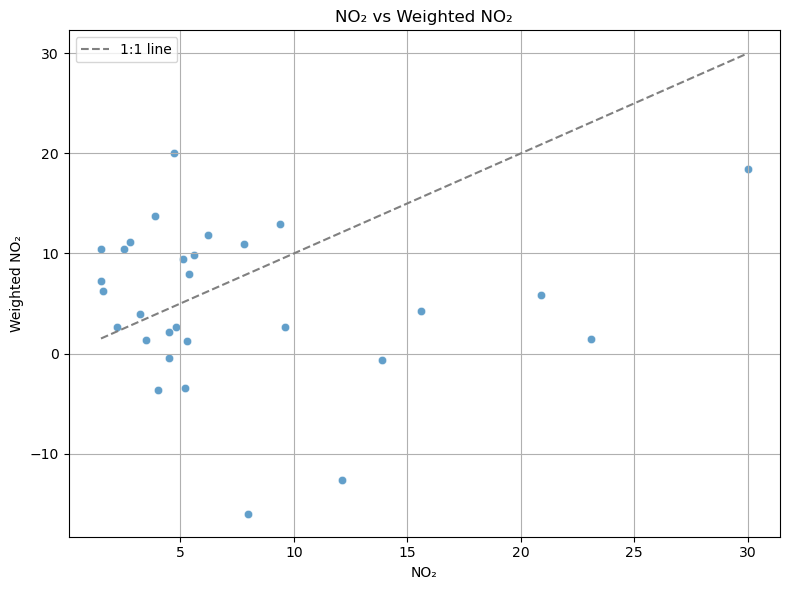

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Example DataFrame (replace with your actual data)
# df = pd.read_csv("your_data.csv")  # if loading from a file

# Plotting
plt.figure(figsize=(8, 6))
sns.scatterplot(data=check, x='no2', y='weighted_no2', alpha=0.7)
plt.plot([check['no2'].min(), check['no2'].max()],
         [check['no2'].min(), check['no2'].max()],
         linestyle='--', color='gray', label='1:1 line')
plt.xlabel("NO₂")
plt.ylabel("Weighted NO₂")
plt.title("NO₂ vs Weighted NO₂")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
